In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils, grid_utils

import bootstrap_confidence

In [3]:

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)

    
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [6]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_linear1vschecker_bootstrap_correctonly.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']
signedconf_hardtrials_boot.shape

(7, 8, 2, 3, 1000)

In [26]:
task_names = ['Linear (1)','Checker'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:])[[0,2],:]


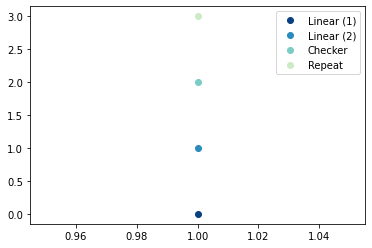

In [22]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:])

plt.figure()
for ti in range(4):
    plt.plot(1,ti, 'o',color=task_colors[ti,:])
plt.legend(task_names)

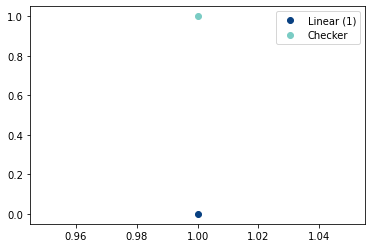

In [25]:
task_names = ['Linear (1)','Checker'];
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:])[[0,2],:]

plt.figure()
for ti in range(2):
    plt.plot(1,ti, 'o',color=task_colors[ti,:])
plt.legend(task_names)

Text(0.5, 0.98, 'Centermost trials, mean +/- SEM across subjects')

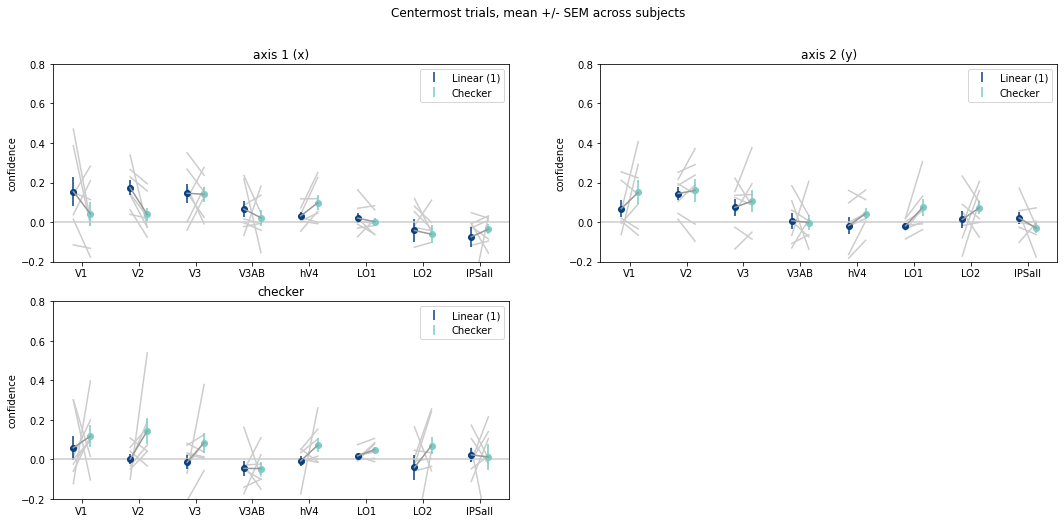

In [27]:
vals = np.mean(signedconf_hardtrials_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,8))


for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)', 'checker']):

    plt.subplot(2,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    # non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

    for ti in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        plt.plot(x_ticks, meanvals[:,ti,ii], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti,ii], \
                         semvals[:,ti,ii], \
                         xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,:,ii],'-',color=[0.6, 0.6, 0.6])
        
        plt.plot(ri+x_jitter, vals[:,ri,:,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
#         if non_overlapping[ri]:
#             yval = np.max(cihigh[ri,:,ii])+0.02
#             plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.80])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names)
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, mean +/- SEM across subjects')


In [28]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)', 'checker']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,:,ii]
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence w/r/t %s, hardest trials'%(axis_name))
    print(anova_result)



Anova for confidence w/r/t axis 1 (x), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       4.385966     7.0    42.0  0.0010
task      2.819951     1.0     6.0  0.1441
roi:task  1.304098     7.0    42.0  0.2722

Anova for confidence w/r/t axis 2 (y), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       4.377160     7.0    42.0  0.0010
task      1.803286     1.0     6.0  0.2279
roi:task  1.034499     7.0    42.0  0.4220

Anova for confidence w/r/t checker, hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       2.472179     7.0    42.0  0.0322
task      2.307150     1.0     6.0  0.1796
roi:task  0.588348     7.0    42.0  0.7615


In [30]:

axis_names = ['axis 1 (x)','axis 2 (y)', 'checker']
for ii in [0,1,2]:
    
    ti_pair = [0,1]

    vals = np.mean(signedconf_hardtrials_boot, axis=4)

    tstats = np.zeros((n_rois,),dtype=float)
    pvals = np.zeros((n_rois,),dtype=float)
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 2342344
    for rr in range(n_rois):

        vals1 = vals[:,rr,ti_pair[0],ii]
        vals2 = vals[:,rr,ti_pair[1],ii]

        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals[rr] = p
        tstats[rr] = t;

        # how many subjects go in same direction?
        subj_diffs = vals1-vals2
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats, \
                            'pvalue': pvals, \
                            'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print('\nclassify %s'%(axis_names[ii]))
    print('%s task > %s task'%(task_names[ti_pair[0]], task_names[ti_pair[1]]))

    print(task_df.round(3))


classify axis 1 (x)
Linear (1) task > Checker task
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           1.204   0.261             5
V2                           3.201   0.016             7
V3                           0.092   0.950             4
V3AB                         0.598   0.627             4
hV4                         -1.970   0.123             5
LO1                          0.749   0.523             4
LO2                          0.497   0.650             4
IPSall                      -0.577   0.737             4

classify axis 2 (y)
Linear (1) task > Checker task
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -1.124   0.393             4
V2                          -0.459   0.661             4
V3                          -0.666   0.554             4
V3AB                         0.141   0.863             4
hV4                         -2.507   0.065             6
LO1                         -2.654   0.01